In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [2]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [13]:
#导入csv数据集
train_data = pd.read_csv('train.csv',encoding='gbk')
test_data = pd.read_csv('testA.csv',encoding='gbk')

In [14]:
#2、对象类型特征转换到数值
train_data['employmentLength'].replace('10+ years','10 years',inplace=True)
train_data['employmentLength'].replace('< 1 year','0 years',inplace=True)
test_data['employmentLength'].replace('10+ years','10 years',inplace=True)
test_data['employmentLength'].replace('< 1 year','0 years',inplace=True)
train_data['employmentLength'] = train_data['employmentLength'].apply(lambda x: x if pd.isnull(x) else np.int8(x.split()[0]))
test_data['employmentLength'] = test_data['employmentLength'].apply(lambda x: x if pd.isnull(x) else np.int8(x.split()[0]))
train_data['earliesCreditLine'] = train_data['earliesCreditLine'].apply(lambda x: int(x[-4:]))
test_data['earliesCreditLine'] = test_data['earliesCreditLine'].apply(lambda x: int(x[-4:]))

#4、修改类别特征
for data in [train_data,test_data]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
#4.1对类别特征以及非连续特征
train_data = pd.get_dummies(train_data,columns=['grade','subGrade','employmentLength','homeOwnership'])
test_data = pd.get_dummies(test_data,columns=['grade','subGrade','employmentLength','homeOwnership'])

In [15]:
from sklearn.model_selection import KFold
# 分离数据集，方便进行交叉验证
X_train = train_data.drop(['id','issueDate','isDefault'], axis=1)
X_test = test_data.drop(['id','issueDate'], axis=1)
y_train = train_data['isDefault']

# 5折交叉验证
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

In [16]:
"""对训练集数据进行划分，分成训练集和验证集，并进行相应的操作"""
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[420]	valid_0's auc: 0.730366


未调参前lightgbm单模型在验证集上的AUC：0.730365885301812


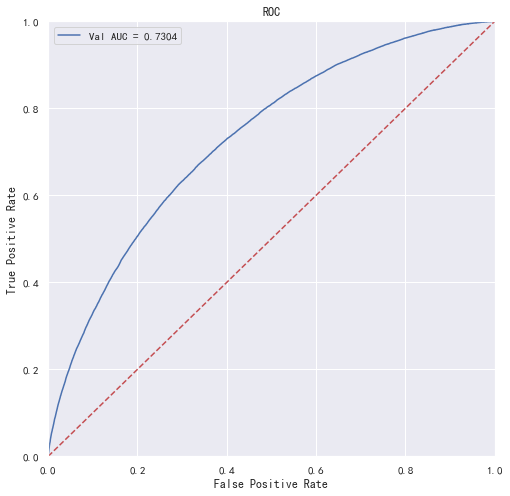

In [17]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

"""预测并计算roc的相关指标"""
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('未调参前lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [18]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',
        
                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'silent': True,
                'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************


C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[598]	valid_0's auc: 0.730614
[0.7306138447274103]
************************************ 2 ************************************


C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[796]	valid_0's auc: 0.726701
[0.7306138447274103, 0.7267007143379272]
************************************ 3 ************************************


C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[553]	valid_0's auc: 0.73083
[0.7306138447274103, 0.7267007143379272, 0.730829682830527]
************************************ 4 ************************************


C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[557]	valid_0's auc: 0.729263
[0.7306138447274103, 0.7267007143379272, 0.730829682830527, 0.7292626242889242]
************************************ 5 ************************************


C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\Users\Nicolas\Anaconda3\envs\py3\lib\site-packages\lightgbm\basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[616]	valid_0's auc: 0.729251
[0.7306138447274103, 0.7267007143379272, 0.730829682830527, 0.7292626242889242, 0.7292514459322346]
lgb_scotrainre_list:[0.7306138447274103, 0.7267007143379272, 0.730829682830527, 0.7292626242889242, 0.7292514459322346]
lgb_score_mean:0.7293316624234046
lgb_score_std:0.0014711319029105468


In [20]:
"""通过网格搜索确定最优参数"""
from sklearn.model_selection import GridSearchCV

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0, 
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001, 
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None):
    # 设置5折交叉验证
    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )
    
    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    grid_search = GridSearchCV(estimator=model_lgb, 
                               cv=cv_fold,
                               param_grid=param_grid,
                               scoring='roc_auc'
                              )
    grid_search.fit(X_train, y_train)

    print('模型当前最优参数为:{}'.format(grid_search.best_params_))
    print('模型当前最优得分为:{}'.format(grid_search.best_score_))

In [21]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', bjective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, X_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    
    return val

In [ ]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.7287   |  0.8659   |  54.96    |  0.9162   |  19.0     |  3.692    |  64.09    |  0.3885   |  96.16    |  8.811    |  5.984    |


In [ ]:
"""显示优化结果"""
bayes_lgb.max

In [ ]:
"""调整一个较小的学习率，并通过cv函数确定当前最优的迭代次数"""
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
                    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    train_set=train_matrix,
    early_stopping_rounds=1000, 
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    params=base_params_lgb,
    metrics='auc',
    seed=0
)

print('迭代次数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))

In [ ]:
import lightgbm as lgb
"""使用lightgbm 5折交叉验证进行建模预测"""
cv_scores = []
for i, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = X_train.iloc[train_index], y_train[train_index], X_train.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 14,
                'max_depth': 19,
                'min_data_in_leaf': 37,
                'min_child_weight':1.6,
                'bagging_fraction': 0.98,
                'feature_fraction': 0.69,
                'bagging_freq': 96,
                'reg_lambda': 9,
                'reg_alpha': 7,
                'min_split_gain': 0.4,
                'nthread': 8,
                'seed': 2020,
                'silent': True,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=14269, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

In [ ]:
""""""
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
}

"""使用训练集数据进行模型训练"""
final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=13000, verbose_eval=1000, early_stopping_rounds=200)

"""预测并计算roc的相关指标"""
val_pre_lgb = final_model_lgb.predict(X_val)
fpr, tpr, threshold = metrics.roc_curve(y_val, val_pre_lgb)
roc_auc = metrics.auc(fpr, tpr)
print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
"""画出roc曲线图"""
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()

In [ ]:
"""保存模型到本地"""
# 保存模型
import pickle
pickle.dump(final_model_lgb, open('dataset/model_lgb_best.pkl', 'wb'))